In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import joblib

In [3]:
DATA_PATH = "/content/adult.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (32561, 15)
Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df.replace("?", np.nan, inplace=True)
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].str.strip()
df.drop_duplicates(inplace=True)
print("After cleaning shape:", df.shape)
df.head()

After cleaning shape: (32537, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
(df.isna().mean().sort_values(ascending=False) * 100).round(2)

,0
occupation,5.66
workclass,5.64
native.country,1.79
fnlwgt,0.00
education,0.00
education.num,0.00
age,0.00
marital.status,0.00
relationship,0.00
sex,0.00


In [6]:
TARGET_COL = "income"
y = (df[TARGET_COL] == ">50K").astype(int)
X = df.drop(columns=[TARGET_COL])
print("Target counts:")
print(y.value_counts())
print("\nTarget ratio:")
print(y.value_counts(normalize=True).round(3))

Target counts:
income
0    24698
1     7839
Name: count, dtype: int64

Target ratio:
income
0    0.759
1    0.241
Name: proportion, dtype: float64


In [7]:
if "education" in X.columns and "education.num" in X.columns:
    X = X.drop(columns=["education"])
print("Columns after drop:", X.columns.tolist())

Columns after drop: ['age', 'workclass', 'fnlwgt', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']


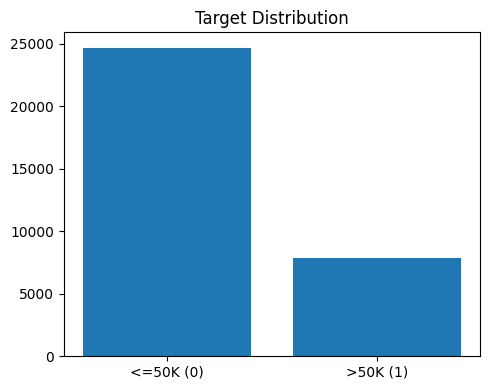

In [8]:
plt.figure(figsize=(5,4))
counts = y.value_counts()
plt.bar(["<=50K (0)", ">50K (1)"], counts.values)
plt.title("Target Distribution")
plt.tight_layout()
plt.show()

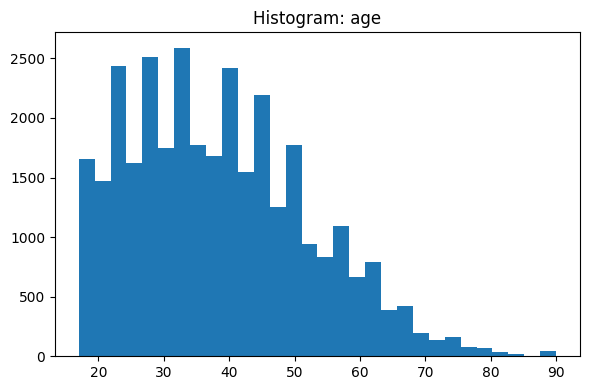

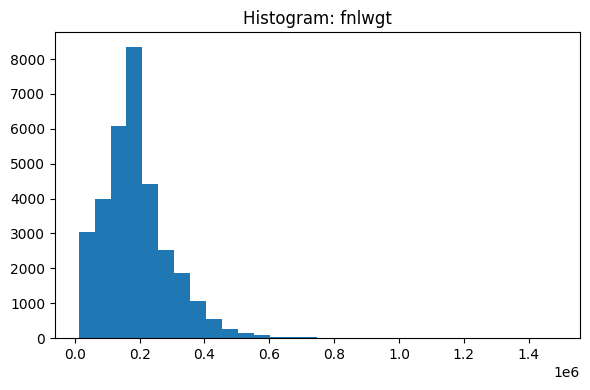

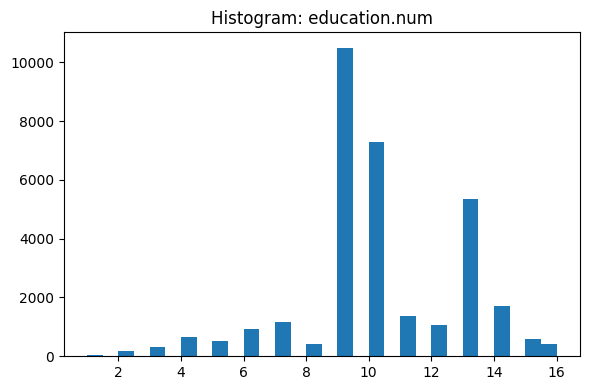

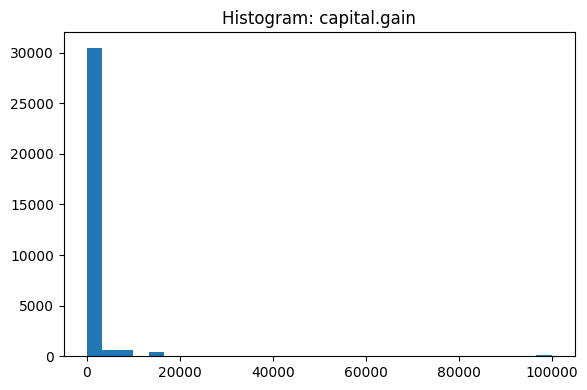

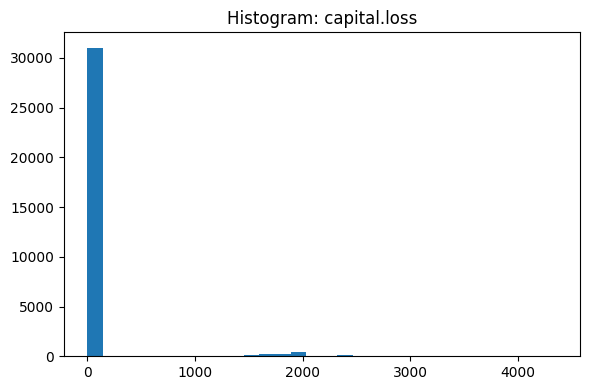

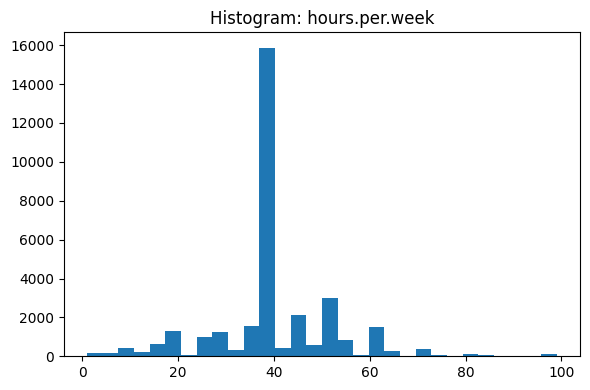

In [9]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(X[c].dropna(), bins=30)
    plt.title(f"Histogram: {c}")
    plt.tight_layout()
    plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42,stratify=y)
print("Train:", X_train.shape)
print("Test :", X_test.shape)

Train: (26029, 13)
Test : (6508, 13)


In [13]:
cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[("num", numeric_pipeline, num_cols),("cat", categorical_pipeline, cat_cols)])

In [14]:
model = LogisticRegression(max_iter=2000, C=0.5)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education.num',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country'])])),
                ('model', LogisticRegression(C=0.5, max_iter=2000))])

In [15]:
pipeline.fit(X_train, y_train)
print("Training done.")

Training done.


In [16]:
y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print("Accuracy:", round(acc, 4))
print("F1      :", round(f1, 4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8519
F1      : 0.6603

Confusion Matrix:
[[4607  333]
 [ 631  937]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8795    0.9326    0.9053      4940
           1     0.7378    0.5976    0.6603      1568

    accuracy                         0.8519      6508
   macro avg     0.8087    0.7651    0.7828      6508
weighted avg     0.8454    0.8519    0.8463      6508



In [17]:
for C in [1.0, 0.5, 0.2, 0.1, 0.05]:
    pipeline_C = Pipeline(steps=[("preprocess", preprocess),("model", LogisticRegression(max_iter=2000, C=C))])
    pipeline_C.fit(X_train, y_train)
    pred = pipeline_C.predict(X_test)
    print("C =", C, "| F1 =", round(f1_score(y_test, pred), 4), "| Acc =", round(accuracy_score(y_test, pred), 4))

C = 1.0 | F1 = 0.6577 | Acc = 0.8508
C = 0.5 | F1 = 0.6603 | Acc = 0.8519
C = 0.2 | F1 = 0.6587 | Acc = 0.8513
C = 0.1 | F1 = 0.6582 | Acc = 0.8511
C = 0.05 | F1 = 0.6549 | Acc = 0.8503


In [20]:
import joblib

MODEL_PATH = "adult_simple_pipeline.joblib"
joblib.dump(pipeline, MODEL_PATH)

print("Saved to:", MODEL_PATH)

Saved to: adult_simple_pipeline.joblib
